In [1]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import pandas as pd
import numpy as np

save_dir = "../plots/lossy_compression/"

In [2]:
jpeg_stats_file = "../experimental_data/jpeg/stats.json"
balle_clic_stats_file = "../experimental_data/kodak_balle/stats.json"

rec_clic_stats_file = "/scratch/gf332/models/relative-entropy-coding/clic2019/large_resnet_vae/beta_0.500_lamb_0.100_laplace_target_bpp_0.300/results.csv"



In [3]:
with open(jpeg_stats_file, 'r') as f:
    jpeg_df = pd.read_json(f)
    
with open(balle_clic_stats_file, 'r') as f:
    balle_df = pd.read_json(f)
    balle_df = balle_df.rename(lambda x: x[1:], axis=1)
    
with open(rec_clic_stats_file, 'r') as f:
    rec_df = pd.read_csv(f, sep=',')
    
    rec_df = rec_df.T

    rec_df.columns = rec_df.iloc[0]

    rec_df = rec_df.drop(rec_df.index[0])

In [4]:
img_name = 'kodim02.png'

jpeg_img_df = pd.read_json(jpeg_df[img_name].to_json())
balle_img_df = pd.read_json(balle_df[img_name].to_json())

jpeg_img_df.loc["model"] = "jpeg"
balle_img_df.loc["model"] = "balle"

# Put the columns in order
jpeg_img_df = jpeg_img_df.reindex(sorted(jpeg_img_df.columns, key=lambda c: int(c.split('_')[1])), axis=1)
balle_img_df = balle_img_df.reindex(sorted(balle_img_df.columns, 
                                           key=lambda c: float(f"0.{c.split('_')[1]}")), axis=1)

ideal_rec_df = pd.DataFrame(rec_df[img_name].apply(float))
actual_rec_df = ideal_rec_df.copy()

ideal_rec_df = ideal_rec_df.rename({" ideal_PSNR": "psnr",
                                    " lossy_BPP": "bpp",
                                    " ideal_MS_SSIM": "ms_ssim"}).loc[["psnr", "bpp", "ms_ssim"]]

actual_rec_df = ideal_rec_df.rename({" PSNR": "psnr",
                                     " comp_lossy_BPP": "bpp",
                                     " MS_SSIM": "ms_ssim"}).loc[["psnr", "bpp", "ms_ssim"]]

ideal_rec_df.loc["model"] = "ideal_rec"
actual_rec_df.loc["model"] = "actual_rec"

In [5]:
joint_df = pd.concat([jpeg_img_df, 
                      balle_img_df, 
                      ideal_rec_df, 
                      actual_rec_df], axis=1).T.astype({"bpp": float,
                                                        "psnr": float,
                                                        "ms_ssim": float})

In [6]:
# Convert MS-SSIM statistic to decibels
joint_df['ms_ssim'] = -10 * np.log(1 - joint_df['ms_ssim'])

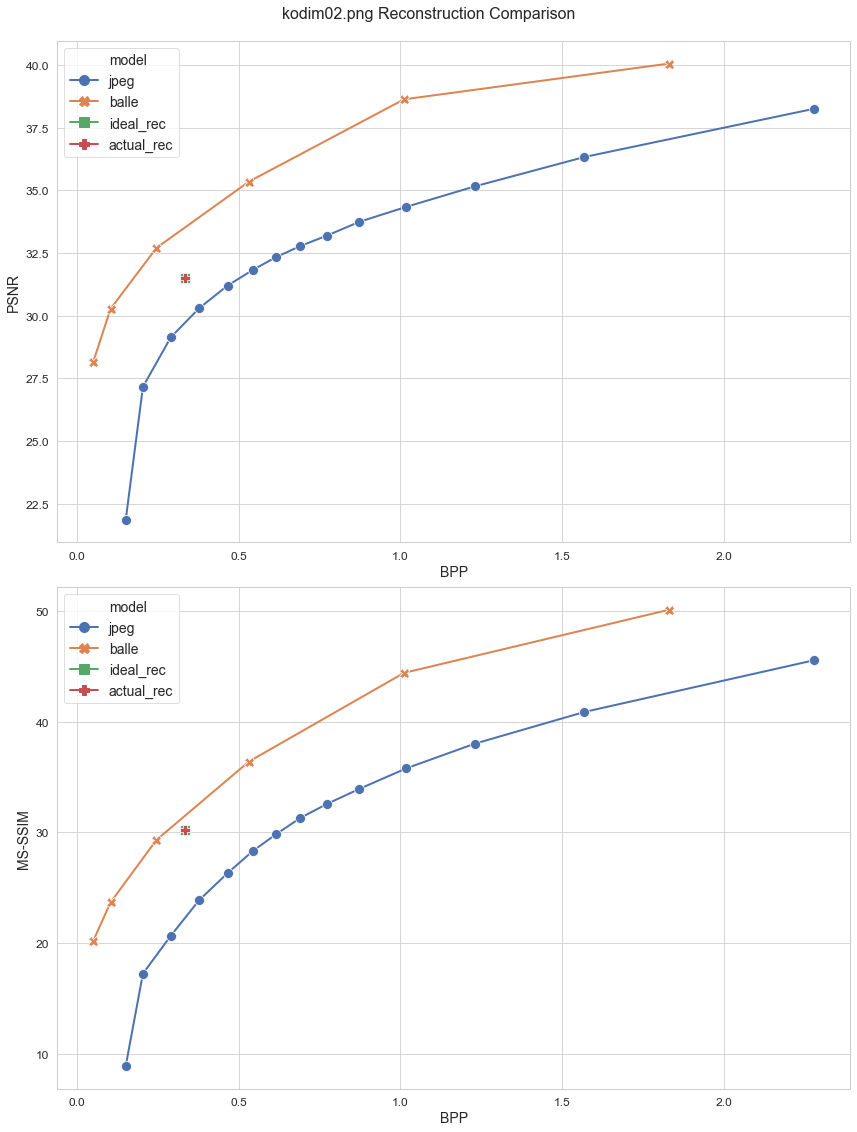

In [9]:
sns.set(style="whitegrid")     
paper_rc = {'lines.linewidth': 2, 'lines.markersize': 10}                  
sns.set_context("paper", rc = paper_rc)  

fig, axes = plt.subplots(nrows=2, figsize=(12, 16))

sns.lineplot(x="bpp", 
             y="psnr", 
             data=joint_df,
             markers=True,
             dashes=False,
             hue='model', 
             style='model',
             ax=axes[0])

axes[0].set_xlabel("BPP", fontsize=14)
axes[0].set_ylabel("PSNR", fontsize=14)
axes[0].tick_params(labelsize=12)
axes[0].legend(fontsize=14)

sns.lineplot(x="bpp", 
             y="ms_ssim", 
             data=joint_df,
             markers=True,
             dashes=False,
             hue='model', 
             style='model',
             ax=axes[1])

axes[1].set_xlabel("BPP", fontsize=14)
axes[1].set_ylabel("MS-SSIM", fontsize=14)
axes[1].tick_params(labelsize=12)
axes[1].legend(fontsize=14)

fig.tight_layout()
fig.subplots_adjust(top=0.95)
fig.suptitle(f"{img_name} Reconstruction Comparison", fontsize=16)

fig.savefig(f"{save_dir}/{img_name}")